In [25]:
import os
path = '/content/drive/MyDrive/CIS520 Machine Learning 2020FALL/project'
os.chdir(path)
os.listdir(path)

['data.csv',
 'logistic_regression_baseline.ipynb',
 'knn_baseline.ipynb',
 'data_preview.ipynb',
 'random_forest_baseline.ipynb']

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

## Baseline

### Prepare datasets

In [27]:
def prepare_data():
  data = pd.read_csv('data.csv')
  labelencoder_y = LabelEncoder()
  data['diagnosis'] = labelencoder_y.fit_transform(data['diagnosis'])
  df_output = data.dropna(axis='columns')

  return df_output


data = prepare_data()

In [24]:
def prepare_datasets(df_input):
  feature_selected = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

  X = df_input[feature_selected]
  y = df_input['diagnosis']

  return X, y


X, y = prepare_datasets(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("training data points: {}".format(X_train.shape))
print("testing data points: {}".format(X_test.shape))

training data points: (398, 10)
testing data points: (171, 10)


### Baseline result

In [5]:
def get_rf_baseline(X_train, y_train, X_test, y_test):
  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  score = clf.score(X_test, y_test)
  recall = recall_score(y_test, y_pred)

  print('RF baseline accuracy:', score)
  print('RF baseline recall:', recall)
  print(classification_report(y_test, y_pred))


get_rf_baseline(X_train, y_train, X_test, y_test)

RF baseline accuracy: 0.9532163742690059
RF baseline recall: 0.9523809523809523
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       108
           1       0.92      0.95      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



## Tuning with more features

### Prepare another dataset with more features

In [6]:
def bigger_datasets(df_input):
  feature_selected = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 
       'radius_worst', 'texture_worst','perimeter_worst', 'area_worst', 
       'smoothness_worst','compactness_worst', 'concavity_worst', 
       'concave points_worst','symmetry_worst', 'fractal_dimension_worst']

  X = df_input[feature_selected]
  y = df_input['diagnosis']

  return X, y


_X, _y = bigger_datasets(data)
_X_train, _X_test, _y_train, _y_test = train_test_split(_X, _y, test_size=0.3, random_state=42)

print("training data points: {}".format(_X_train.shape))
print("testing data points: {}".format(_X_test.shape))

training data points: (398, 20)
testing data points: (171, 20)


In [7]:
get_rf_baseline(_X_train, _y_train, _X_test, _y_test)

RF baseline accuracy: 0.9649122807017544
RF baseline recall: 0.9365079365079365
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       108
           1       0.97      0.94      0.95        63

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



### Cross-validation

In [8]:
pool_estimators = range(10, 101)
pool_criterion = ['gini', 'entropy']
pool_randomstate = range(1, 11)

n_estimators

In [9]:
avg_accs = []
avg_recs = []

for item in pool_estimators:
  clf = RandomForestClassifier(n_estimators=item)
    
  accs = cross_val_score(clf, _X, _y, cv=5)
  recs = cross_val_score(clf, _X, _y, cv=5, scoring='recall')
  avg_accs.append(np.average(accs))
  avg_recs.append(np.average(recs))

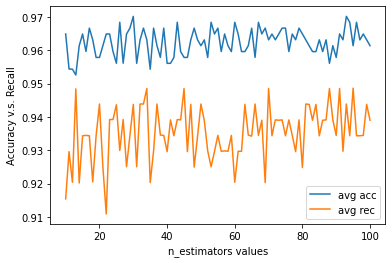

Best average cross-val acc: 0.9701599130569788
corresponding n: 93
Best average cross-val rec: 0.9486157253599113
corresponding n: 95


In [10]:
plt.plot(pool_estimators, avg_accs, label='avg acc')
plt.plot(pool_estimators, avg_recs, label='avg rec')
plt.xlabel("n_estimators values")
plt.ylabel("Accuracy v.s. Recall")
plt.legend(loc='best')
plt.show()

print('Best average cross-val acc:', np.max(avg_accs))
print('corresponding n:', pool_estimators[avg_accs.index(np.max(avg_accs))])
print('Best average cross-val rec:', np.max(avg_recs))
print('corresponding n:', pool_estimators[avg_recs.index(np.max(avg_recs))])

criterion

In [11]:
avg_accs = []
avg_recs = []

for item in pool_criterion:
  clf = RandomForestClassifier(criterion=item)

  accs = cross_val_score(clf, _X, _y, cv=5)
  recs = cross_val_score(clf, _X, _y, cv=5, scoring='recall')
  avg_accs.append(np.average(accs))
  avg_recs.append(np.average(recs))

cv_result = {
    'criterion':pool_criterion,
    'average accuracy':avg_accs,
    'average recall':avg_recs
}

result_frame = pd.DataFrame(cv_result)
result_frame

,criterion,average accuracy,average recall
0,gini,0.959603,0.934441
1,entropy,0.959571,0.943743


random_state

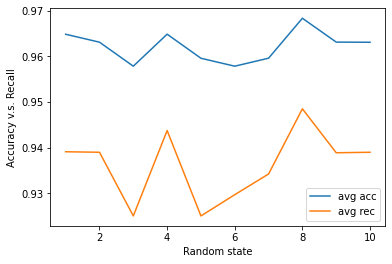

Best average cross-val acc: 0.9683589504735288
corresponding n: 8
Best average cross-val rec: 0.9485049833887043
corresponding n: 8


In [12]:
avg_accs = []
avg_recs = []

for item in pool_randomstate:
  clf = RandomForestClassifier(random_state=item)
    
  accs = cross_val_score(clf, _X, _y, cv=5)
  recs = cross_val_score(clf, _X, _y, cv=5, scoring='recall')
  avg_accs.append(np.average(accs))
  avg_recs.append(np.average(recs))

plt.plot(pool_randomstate, avg_accs, label='avg acc')
plt.plot(pool_randomstate, avg_recs, label='avg rec')
plt.xlabel("Random state")
plt.ylabel("Accuracy v.s. Recall")
plt.legend(loc='best')
plt.show()

print('Best average cross-val acc:', np.max(avg_accs))
print('corresponding n:', pool_randomstate[avg_accs.index(np.max(avg_accs))])
print('Best average cross-val rec:', np.max(avg_recs))
print('corresponding n:', pool_randomstate[avg_recs.index(np.max(avg_recs))])

### Tuning result

In [19]:
# this function calculates the accuracy
def get_rf_accuracy(X_train, y_train, X_test, y_test):
  clf = RandomForestClassifier(n_estimators=70, criterion='entropy', random_state=8)
  clf.fit(X_train, y_train)
  score = clf.score(X_test, y_test)

  return score


acc = get_rf_accuracy(_X_train, _y_train, _X_test, _y_test)
print('Random Forest tuned accuracy:', acc)

Random Forest tuned accuracy: 0.9707602339181286


In [20]:
# this function calculates the recall for Logistic Regression model
def get_rf_recall(X_train, y_train, X_test, y_test):
  clf = RandomForestClassifier(n_estimators=70, criterion='entropy', random_state=8)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  recall = recall_score(y_test, y_pred)

  return recall


rec = get_rf_recall(_X_train, _y_train, _X_test, _y_test)
print('Random Forest tuned recall:', rec)

Random Forest tuned recall: 0.9365079365079365


In [16]:
def rf_report(X_train, y_train, X_test, y_test):
  clf = RandomForestClassifier(n_estimators=70, criterion='entropy', random_state=8)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))


rf_report(_X_train, _y_train, _X_test, _y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       108
           1       0.98      0.94      0.96        63

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



## Tuning with better features

### Univariate feature selection

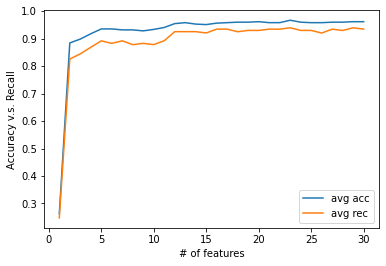

Best acc: 0.9666200900481291
corresponding k: 23
Best rec: 0.9392026578073089
corresponding k: 23


In [39]:
def univariate_selection():
  y_all = data['diagnosis']
  X_all = data.drop(['diagnosis'], axis=1)
  k_values = range(1, 31)

  avg_accs = []
  avg_recs = []
  
  for item in k_values:
    X_new = SelectKBest(chi2, k=item).fit_transform(X_all, y_all)
    clf = RandomForestClassifier(n_estimators=70, criterion='entropy', random_state=8)

    accs = cross_val_score(clf, X_new, y_all, cv=5)
    recs = cross_val_score(clf, X_new, y_all, cv=5, scoring='recall')
    avg_accs.append(np.average(accs))
    avg_recs.append(np.average(recs))

  plt.plot(k_values, avg_accs, label='avg acc')
  plt.plot(k_values, avg_recs, label='avg rec')
  plt.xlabel("# of features")
  plt.ylabel("Accuracy v.s. Recall")
  plt.legend(loc='best')
  plt.show()

  print('Best acc:', np.max(avg_accs))
  print('corresponding k:', k_values[avg_accs.index(np.max(avg_accs))])
  print('Best rec:', np.max(avg_recs))
  print('corresponding k:', k_values[avg_recs.index(np.max(avg_recs))])


univariate_selection()

### Recursive feature elimination (RFE)

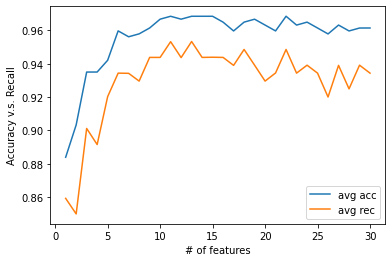

Best acc: 0.968390001552554
corresponding k: 22
Best rec: 0.953266888150609
corresponding k: 13


In [40]:
def recursive_elimination():
  y_all = data['diagnosis']
  X_all = data.drop(['diagnosis'], axis=1)
  k_values = range(1, 31)

  avg_accs = []
  avg_recs = []

  for item in k_values:
    clf = RandomForestClassifier(n_estimators=70, criterion='entropy', random_state=8)
    selector = RFE(clf, n_features_to_select=item)
    X_new = selector.fit_transform(X_all, y_all)

    accs = cross_val_score(clf, X_new, y_all, cv=5)
    recs = cross_val_score(clf, X_new, y_all, cv=5, scoring='recall')
    avg_accs.append(np.average(accs))
    avg_recs.append(np.average(recs))

  plt.plot(k_values, avg_accs, label='avg acc')
  plt.plot(k_values, avg_recs, label='avg rec')
  plt.xlabel("# of features")
  plt.ylabel("Accuracy v.s. Recall")
  plt.legend(loc='best')
  plt.show()

  print('Best acc:', np.max(avg_accs))
  print('corresponding k:', k_values[avg_accs.index(np.max(avg_accs))])
  print('Best rec:', np.max(avg_recs))
  print('corresponding k:', k_values[avg_recs.index(np.max(avg_recs))])


recursive_elimination()

### Select feature

In [ ]:
y_old = data['diagnosis']
X_old = data.drop(['diagnosis'], axis=1)
k = 13

X_new = 